# Using Pitcher Hitter Catcher Model + Pose Estimation to Predict Intended Location

## Pre-work

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi ## if this doesnt work, you have the below
!lspci | grep -i nvidia

/bin/sh: line 1: nvidia-smi: command not found
0000:01:00.0 VGA compatible controller: NVIDIA Corporation GA104 [Geforce RTX 3070 Ti Laptop GPU] (rev a1)
0000:01:00.1 Audio device: NVIDIA Corporation GA104 High Definition Audio Controller (rev a1)


In [1]:
## IF you want to use virtual environments for your jupyter kernel,
## I recomend not running this cell and instead
## handling the clone + requirements install manually.

#!git clone https://github.com/dylandru/BaseballCV.git
%cd BaseballCV
#!pip install -r requirements.txt

## We also need to install other packages that will help us later that are not in reqs
#!pip install moviepy==1.0.3
#!pip install mediapipe==0.10.15


/home/jd/Documents/GitHub/PublicNotebooks/BaseballCVNotebooks/BaseballCV


/home/jd/Documents/GitHub/PublicNotebooks/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Static Image

Creating an intended target from a static image is a lot simpler than with video. With video, you have to determine when the catcher is actually in his final receiving location and not just deaking the batter and/or setting a visual reference point for the pitcher. That will be covered in the following section.

In [2]:
##Import libraries
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
import moviepy.editor as mpy
from scripts.load_tools import LoadTools
from scipy import stats
from IPython.display import Image
import os
import math
import statistics


# Initialize LoadTools class
load_tools = LoadTools()
load_tools.load_dataset("baseball_rubber_home_glove")  # can be any dataset within files

Dataset downloaded and extracted to baseball_rubber_home_glove


'baseball_rubber_home_glove'

In [5]:
# you can choose any picture in any set
SOURCE_IMAGE_PATH = (
    "baseball_rubber_home_glove/baseball_rubber_home_glove/test/images/0009100.jpg"
)
# chose any broadcast mp4, but this one comes with BCV
SOURCE_VIDEO_PATH = "assets/example_broadcast_video.mp4"

In [7]:
## load pitcher catcher model
model_weights_phc = load_tools.load_model("phc_detector")
model_phc = YOLO(model_weights_phc)

## load glove model that includes plate,rubber, ball tracking, need glove, plate,rubber
model_weights_plate = load_tools.load_model(model_alias="glove_tracking")
model_plate = YOLO(model_weights_plate)



Model downloaded to models/pitcher_hitter_catcher_detector/model_weights/pitcher_hitter_catcher_detector_v4.pt


Model downloaded to models/glove_tracking/model_weights/glove_tracking.pt


In [8]:
## some helper functions to make later code cleaner
## simple slope / distance / endpoint functions

def slope_of_line(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    if x1 == x2:
        return None
    slope = (y2 - y1) / (x2 - x1)

    return slope


def find_endpoint(start_point, slope, length, visual=False):
    x1, y1 = start_point

    angle = math.atan(slope)

    delta_x = math.cos(angle) * length
    delta_y = math.sin(angle) * length

    x2 = x1 + delta_x
    y2 = y1 + delta_y
    if visual:
        return (int(x2), int(y2))
    else:
        return (x2, y2)


def distance_between_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the Euclidean distance
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    return distance


# assume that the intended zone is the weighted average of the catcher box
# default weights are
# glove is triple weighted in X
# catcher top is twice weighted with the rest being even
def intended_zone_pixles(x, y, wx=[1, 1, 3, 3], wy=[2, 1, 1, 1]):
    return (np.average(x, weights=wx), np.average(y, weights=wy))


def real_coordinates(izx,izy,plate):
    px1, py1, px2, py2 = plate.xyxy[0]
    px1, py1, px2, py2 = float(px1), float(py1), float(px2), float(py2)

    pw = abs(px1 - px2)
    height = abs(((izy - max([py1, py2])) * 17 / pw))
    side = ((izx - np.mean([px1, px2])) * 17 / pw)
    return (side,height)


def intended_zone(frame, model_phc, model_plate, catcher_depth=6):
    results_phc = model_phc.predict(source=frame, save=False, verbose=False)
    results_plate = model_plate.predict(source=frame, save=False, verbose=False)
    catcher = results_phc[0].boxes[
        torch.where(results_phc[0].boxes.cls == 2.0)[0].tolist()[0]
    ]
    plate = results_plate[0].boxes[
        torch.where(results_plate[0].boxes.cls == 1.0)[0].tolist()[0]
    ]
    rubber = results_plate[0].boxes[
        torch.where(results_plate[0].boxes.cls == 3.0)[0].tolist()[0]
    ]
    glove = results_plate[0].boxes[
        torch.where(results_plate[0].boxes.cls == 0.0)[0].tolist()[0]
    ]
    cx1, cy1, cx2, cy2 = catcher.xyxy[0]
    px1, py1, px2, py2 = plate.xyxy[0]
    rx1, ry1, rx2, ry2 = rubber.xyxy[0]
    gx1, gy1, gx2, gy2 = glove.xyxy[0]
    depth = abs(int(rx1) - int(rx2)) / 2 * 5 / 6

    izx, izy = intended_zone_pixles(
        x=[int(cx1), int(cx2), int(gx1), int(gx2)],
        y=[int(cy1), int(cy2), int(gy1), int(gy2)],
    )

    ground_line_slope = slope_of_line(
        (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
        (
            int(np.mean([int(rx1), int(rx2)])),
            int(np.mean([int(ry1), int(ry2)])) + int(depth),
        ),
    )

    catcher_beyond_pixlewidth = (
        distance_between_points(
            (int(np.mean([int(px1), int(px2)])), int(np.mean([int(py1), int(py2)]))),
            (
                int(np.mean([int(rx1), int(rx2)])),
                int(np.mean([int(ry1), int(ry2)])) + int(depth),
            ),
        )
        / 59.5
        * catcher_depth
    )
    translated = find_endpoint(
        (izx, izy), ground_line_slope, -1 * catcher_beyond_pixlewidth, visual=False
    )
    real_coords = real_coordinates(float(translated[0]), float(izy), plate)

    to_return = {
        "rawX": float(izx),  ## raw X location in Pixles at catcher depth
        "rawY": float(izy),  ## raw Y location in Pixles at catcher depth
        "translatedX": float(
            translated[0]
        ),  ## projected X location in Pixles at front of plate
        "translatedY": float(
            translated[1]
        ),  ## projected Y location in Pixles at front of plate
        "PlateLocSide": float(
            real_coords[0]
        ),  ## Estimated Real World Side Coordinate at front of plate
        "PlateLocHeight": float(
            real_coords[1],
        ),  ## Estimated Real World Height Coordinate at front of plate
    }
    return to_return

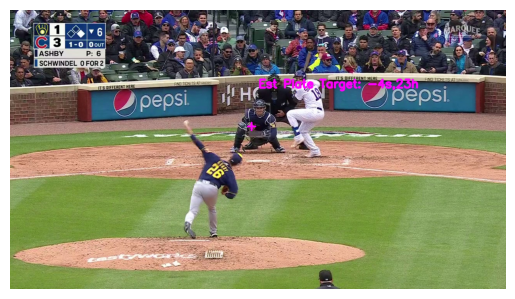

In [9]:
image = cv2.imread(SOURCE_IMAGE_PATH)
shape = image.shape

izr = intended_zone(image, model_phc=model_phc, model_plate=model_plate, catcher_depth=6)
cv2.line(
        image,
        (
            int(izr["translatedX"] - 10),
            int(izr["rawY"]),
        ),
        (
            int(izr["translatedX"] + 10),
            int(izr["rawY"]),
        ),
        (255, 0, 255),
        4,
    )  # vertical target

cv2.line(
        image,
        (
            int(izr["translatedX"]),
            int(izr["rawY"] - 10),
        ),
        (
            int(izr["translatedX"]),
            int(izr["rawY"] + 10),
        ),
        (255, 0, 255),
        4,
    )  # horz target
text = f'Est Plate Target: {int(izr["PlateLocSide"])}s,{int(izr["PlateLocHeight"])}h'
cv2.putText(
        image,
        text,
        org=(
            int(izr["rawX"]),
            int(izr["rawY"] - 100),
        ),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1,
        color=(255, 0, 255),  # White color
        thickness=4,
        lineType=cv2.LINE_AA,
    )

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

The purple cross is the estimated intended location of the pitch on the plane created by the front of the plate. 
Why don't we translate the y? Well its my dumb way of accounting for gravity. Unless you're throwing a riseball, in order to hit your catcher's target, the ball needs to cross the plate higher than the intended location. By leaving y unaffected by the translation, we can crudly account for this.
A full model in production should handle this dependent on what you're using to measure pitch location.

In [11]:
## Plate Loc Side and Plate Loc height in Inches of the Intended Target
izr

{'rawX': 641.75,
 'rawY': 300.0,
 'translatedX': 623.6995798319327,
 'translatedY': 325.4117647058824,
 'PlateLocSide': -4.506897032541338,
 'PlateLocHeight': 23.759160589346862}

Now all you would have to do is match the ball flight data with the intended location and calculate the difference.

## Video

The added challenge of video stems from what frame to actually set the intended location? We set it at the estimated release point.

In [13]:
## needed models
## load pitcher catcher model
model_weights_phc = load_tools.load_model("phc_detector")
model_phc = YOLO(model_weights_phc)

## load glove model that includes plate,rubber, ball tracking, need glove, plate,rubber
model_weights_plate = load_tools.load_model(model_alias="glove_tracking")
model_plate = YOLO(model_weights_plate)

Model found at models/pitcher_hitter_catcher_detector/model_weights/pitcher_hitter_catcher_detector_v4.pt
Model found at models/glove_tracking/model_weights/glove_tracking.pt


In [14]:
## If you want an explainer of this code, I can do another notebook that breaks it down. For now, know 
## that it outputs the release frame number
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np

## turn off mediapipes non error logging
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
## 

## get the pose model
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
#### Create Detector, Set Options
base_options = python.BaseOptions(model_asset_path="pose_landmarker.task")
options = vision.PoseLandmarkerOptions(
    base_options=base_options, output_segmentation_masks=True,min_pose_detection_confidence = .5, min_tracking_confidence = .5,
      min_pose_presence_confidence = .5,)
detector = vision.PoseLandmarker.create_from_options(options)

## load BaseballCV models
model_phc = YOLO(load_tools.load_model("phc_detector"))
model_plate = YOLO(load_tools.load_model(model_alias="glove_tracking"))

def estimated_release_frame(xyz_dict):
    # get estimated throwing hand, if the range of RW is larger than LW then RW is the throwing hand (think about the rotation of the body)
    # if the right hand is covering more ground, its probably the throwing hand
    throw_hand = 'rw' if max(xyz_dict["rw"]['z']) - min(xyz_dict["rw"]['z']) > max(xyz_dict["lw"]['z']) - min(xyz_dict["lw"]['z']) else 'lw'
    glove_hand = 'lw' if throw_hand == 'rw' else 'rw'

    ## what frame does the arm reach maximam distance toward camera
    max_index = xyz_dict[throw_hand]['z'].index(min(xyz_dict[throw_hand]['z']))

    ## get points around key frame, our release is probably in here
    local_x_lw = xyz_dict[glove_hand]['x'][(max_index - 10) : (max_index + 10)]
    local_x_rw = xyz_dict[throw_hand]["x"][(max_index - 10) : (max_index + 10)]
    local_frame = xyz_dict["frame"][(max_index - 10) : (max_index + 10)]

    #get the max distance between wrists in x plane within this region
    max_distance = [abs(l - r) for l, r in zip(local_x_lw, local_x_rw)]

    ## assume release is the maximum distance between the wrists within the range we searched
    max_index = max_distance.index(max(max_distance))

    return local_frame[max_index]

def release_frame_estimation(video,model_phc,pose_detector):

    # infer pitcher catcher location 
    results_phc = model_phc.predict(source=video, save=False)
    

    ## load video into cv2 and initialize mediapipe locations
    cap = cv2.VideoCapture(video)
    mp_pose = mp.solutions.pose

    #initialize storage variables
    xyz_dict = {key: {"x": [], "y": [], "z": []} for key in ["lw", "rw", "ls", "rs"]}
    xyz_dict["frame"] = []
    i= 0
    ## loop through each result from PHC model
    for result in results_phc:

        ## get the index of the pitcher
        index = torch.where(result.boxes.cls == 1)[0].tolist()

        #if there is no pitcher detected, move on
        if index == []:
            i=i+1
            continue        
        else:
            ## get pitcher box location
            pitcher = result.boxes[index[0]]
            x1, y1, x2, y2 = pitcher.xyxy[0]
            
            ## get the frame and crop the pitcherbox
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            cropped_image = frame[
                int(y1) : int(y2), int(x1) : int(x2)
            ]  # Note the order of dimensions (y, x)
            cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

            ## have MP eval just the pitcherbox
            mp_image_eval = mp.Image(
                image_format=mp.ImageFormat.SRGB, data=cropped_image_rgb
            )
            detection_result = pose_detector.detect(mp_image_eval)

            ## if we dont detect any poses, skip it
            if len(detection_result.pose_landmarks) == 0:
                continue

            else:
                ## go through the resulst and get the locations of the wrists and shoulders
                ## shoulders arent currently used, but could be used to make it more accurate.
                xyz_dict["lw"]["z"].append(
                    detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].z
                )
                xyz_dict["rw"]["z"].append(
                    detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].z
                )
                xyz_dict["ls"]["z"].append(
                    detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].z
                )
                xyz_dict["rs"]["z"].append(
                    detection_result.pose_landmarks[0][
                        mp_pose.PoseLandmark.RIGHT_SHOULDER
                    ].z
                )
                xyz_dict["lw"]["x"].append(
                    detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].x
                )
                xyz_dict["rw"]["x"].append(
                    detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].x
                )
                xyz_dict["ls"]["x"].append(
                    detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].x
                )
                xyz_dict["rs"]["x"].append(
                    detection_result.pose_landmarks[0][
                        mp_pose.PoseLandmark.RIGHT_SHOULDER
                    ].x
                )
                xyz_dict["lw"]["y"].append(
                    detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_WRIST].y
                )
                xyz_dict["rw"]["y"].append(
                    detection_result.pose_landmarks[0][mp_pose.PoseLandmark.RIGHT_WRIST].y
                )
                xyz_dict["ls"]["y"].append(
                    detection_result.pose_landmarks[0][mp_pose.PoseLandmark.LEFT_SHOULDER].y
                )
                xyz_dict["rs"]["y"].append(
                    detection_result.pose_landmarks[0][
                        mp_pose.PoseLandmark.RIGHT_SHOULDER
                    ].y
                )
                xyz_dict["frame"].append(i)
            i=i+1    
            
            ## return the edtimated relase frame based on the results 
    return estimated_release_frame(xyz_dict)


def video_intended_location(video,model_phc,model_plate,pose_detect,output_path,catcher_depth = 6,target_appear_lag = 60):
    
    # load video into CV2
    cap = cv2.VideoCapture(video)
    # Get video properties (width, height, FPS) as well as codec for output
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")

    # estimate the release frame
    release_frame = release_frame_estimation(video,model_phc,pose_detect)

    ## get the frame that the release happens and calc the intended zone
    cap.set(cv2.CAP_PROP_POS_FRAMES, release_frame)
    ret, staticframe = cap.read()
    izr = intended_zone(staticframe, model_phc=model_phc, model_plate=model_plate, catcher_depth=catcher_depth)

    ## create and output object to store the frames and conduct the write
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # loop de loop through the frames
    for i in range(0, total_frames):

        #read the ith frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()

        ####### Plots the target and the words. Target wont show up until the frame lag is exceeded
        if i >= target_appear_lag: 
            cv2.line(
                frame,
                (
                    int(izr["translatedX"] - 10),
                    int(izr["rawY"]),
                ),
                (
                    int(izr["translatedX"] + 10),
                    int(izr["rawY"]),
                ),
                (255, 0, 255),
                4,
            )  # vertical target

            cv2.line(
                frame,
                (
                    int(izr["translatedX"]),
                    int(izr["rawY"] - 10),
                ),
                (
                    int(izr["translatedX"]),
                    int(izr["rawY"] + 10),
                ),
                (255, 0, 255),
                4,
            )  # horz target
            text = f'Est Plate Target: {int(izr["PlateLocSide"])}s,{int(izr["PlateLocHeight"])}h'
            cv2.putText(
                frame,
                text,
                org=(
                    int(izr["rawX"]),
                    int(izr["rawY"] - 100),
                ),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 0, 255),  # White color
                thickness=4,
                lineType=cv2.LINE_AA,
            )
        ######## Plots the target and the words

        out.write(frame)
    cap.release()
    out.release()
    return izr

Model found at models/pitcher_hitter_catcher_detector/model_weights/pitcher_hitter_catcher_detector_v4.pt
Model found at models/glove_tracking/model_weights/glove_tracking.pt


I0000 00:00:1729519387.138840    2091 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1729519387.184101    2224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729519387.248838    2224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Our method says that the intended location for this pitch will come at frame "release_frame". Below is the positon of the catcher at that point. That looks pretty close. 

In [ ]:
output_path = 'results.mp4'
izr = video_intended_location(
    SOURCE_VIDEO_PATH,
    model_phc,
    model_plate,
    detector,
    output_path,
    catcher_depth=6,
    target_appear_lag=60,
)

In [17]:
izr

{'rawX': 620.75,
 'rawY': 353.0,
 'translatedX': 600.1785714285714,
 'translatedY': 376.4957983193277,
 'PlateLocSide': -6.330770335613261,
 'PlateLocHeight': 19.812181607436177}

In [18]:
video = mpy.VideoFileClip(output_path)
resized_video = video.resize((640, 360))  # Resize as needed
mpy.ipython_display(resized_video)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Same thing with image, we can use the trackman/hawkeye/ball flight data to match it up and estimate the miss distance!